In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import h5py, bisect, heapq
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import iqr
np.random.seed(32815)

In [2]:
with h5py.File('digits.h5')as f:
    images = f['images'].value
    labels = f['labels'].value

# normalize data
images = images/np.max(images)
print(images.shape)

(120000, 9, 9)


Choose digit for this exercise and filter data

In [3]:
digit = 6

In [4]:
mask = labels == digit
x = images[mask]
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
y = labels[mask]

Plot of random images from digit dataset

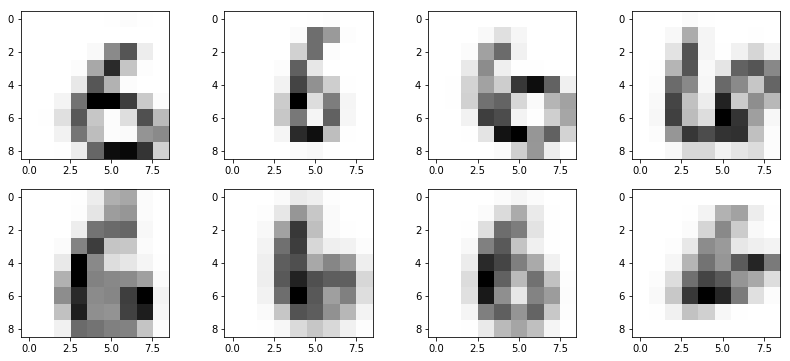

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax, choice in zip(axes.flatten(), np.random.choice(x.shape[0], 8)):
    ax.imshow(x[choice].reshape(9,9), cmap='Greys')

# 1. Data Generation with Naive Bayes

Using Histogram and NaiveBayesClassifier classes provided on Moodle (removed unused methods for readability

In [6]:
class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)
        # Normalize bins based on number of instances
        self.probs = self.heights / self.num_instances

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

In [7]:
# create naive bayes histograms
nb = NaiveBayesClassifier()
nb.train(x, y)

In [8]:
# function to sample image from histograms
# function has different arguments than on assignment,
# because of the provided NaiveBayes class
def sample_naive_bayes(nb, digit):
    # empty image
    image = np.empty(len(nb.histograms[digit]))
    
    # for all histograms
    for j, hist in enumerate(nb.histograms[digit]):
        r = np.random.random()
        # cumulative histogram
        cumhist = np.cumsum(hist.probs)
        l = 0
        # find smallest l with Q_l > random
        while cumhist[l] < r and l < len(cumhist)-1:
            l += 1
        # random sample between bin l boundaries
        image[j] = np.random.uniform(*hist.bin_edges[l:l+2])
    return image.reshape(9,9)

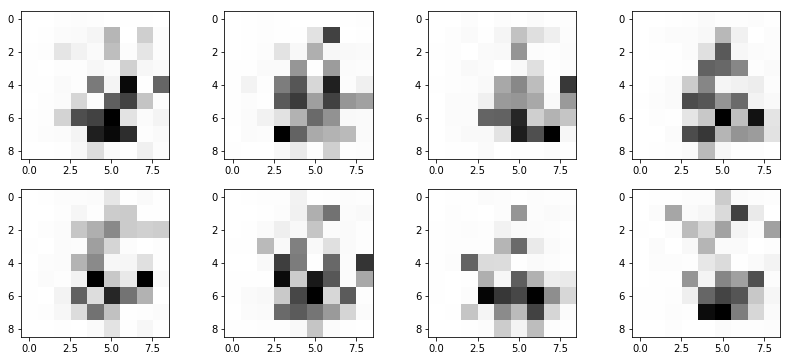

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(sample_naive_bayes(nb, digit), cmap='Greys')

# 2. Data Generation & Classification with Density Trees

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
class DataPass: # empty class which can be accessed by all tree nodes
    pass

class Node:
    def __init__(self, data, bbox, dataobj=None):
        self.__left, self.__right = None, None
        self.data = data
        self.N = data.shape[0]
        self.vol = np.product(bbox[:,1]-bbox[:,0])
        assert(self.vol > 0)
        self.bbox = np.array(bbox)
        self.dataobj = dataobj
        
    def find_split(self, score_func, threshhold_count=10):
        threshholds = np.empty(self.bbox.shape[0])
        self.best_split = {'score' : 0}
        for j, box in enumerate(self.bbox):
            for t in np.linspace(*box, threshhold_count+2)[1:-1]:
                leftmask = self.data[:,j] < t
                V_red = self.vol / (box[1] - box[0])
                Vl = (t - box[0]) * V_red
                Vr = (box[1] - t) * V_red
                Nl = np.count_nonzero(leftmask)
                Nr = self.N - Nl
                score = score_func(self.vol, self.N, self.dataobj.Ntot, Nl, Vl, Nr, Vr) 
                if score > self.best_split['score']:
                    self.best_split['score'] = score
                    self.best_split['feature'] = j
                    self.best_split['threshhold'] = t
        return (-self.best_split['score'], self)
    
    def split(self):
        t = self.best_split['threshhold']
        j = self.best_split['feature']
        lmask = self.data[:,j] < t
        lcount = np.count_nonzero(lmask)
        if lcount == 0 or lcount == lmask.shape[0]:
            return False
        bbox_l, bbox_r = np.copy(self.bbox), np.copy(self.bbox)
        bbox_l[j, 1] = t
        bbox_r[j, 0] = t
        self.left = Node(self.data[lmask], bbox_l)
        self.right = Node(self.data[~lmask], bbox_r)
        self.t = t
        self.j = j
        del self.data
        return True
    
    @property
    def prob(self):
        return self.N / self.dataobj.Ntot
    
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, node):
        self.__left = node
        self.__left.dataobj = self.dataobj
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, node):
        self.__right = node
        self.__right.dataobj = self.dataobj

def score_sqr(V, N, Ntot, Nl, Vl, Nr, Vr):
    p = N / Ntot / V
    pl = Nl / Ntot / Vl
    pr = Nr / Ntot / Vr
    return -p**2 * V**2 + pl**2 * Vl + pr**2 * Vr
    
def fit_density_tree1(features, tau):
    bincount = int(tau * features.shape[0]**(1/3))

    bbox_root = np.empty((features.shape[1], 2))
    for i in range(features.shape[1]):
        bbox_root[i, 0] = np.min(features[:,i])
        bbox_root[i, 1] = np.max(features[:,i])
    
    
    obj = DataPass() # Data object accessible in all nodes
    obj.Ntot = features.shape[0]
    root = Node(features, bbox_root, dataobj=obj)
    
    leafs = [root.find_split(score_sqr)]

    i = 0
    while i < bincount-2 and len(leafs) != 0:
        _, node = heapq.heappop(leafs)
        if node.split() is False:
            continue
        heapq.heappush(leafs, node.left.find_split(score_sqr))
        heapq.heappush(leafs, node.right.find_split(score_sqr))
        i += 1
    return root


In [24]:
tree1 = fit_density_tree1(x, 50)

In [27]:
def traverse_tree(root, action):
    if root is None:
        return
    traverse_tree(root.left, action)
    action(root)
    traverse_tree(root.right, action)

def action(node):
    if node.left is None:
        print(node.N)

In [22]:
def prob_check(node):
    if node.left is None:
        return
    else:
        assert(node.prob - node.left.prob - node.left.prob < 1e-16)

In [23]:
traverse_tree(tree1, prob_check)

In [32]:
def sample_density_tree(node):
    t = np.random.random()
    while node.left is not None:
        if t <= node.prob:
            node = node.left
        else:
            t -= node.prob
            node = node.right
    return np.fromiter((np.random.uniform(*box) for box in node.bbox), dtype='float', count=node.bbox.shape[0]).reshape(9,9)

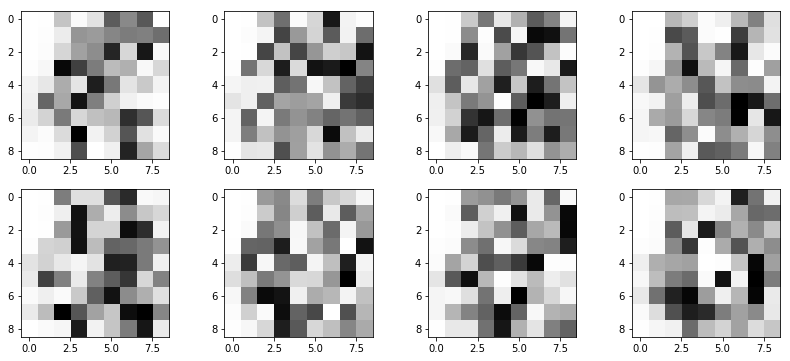

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(sample_density_tree(tree1), cmap='Greys')

# 3. Data Generation with a Multi-dimensional Gaussian

In [32]:
# Fit feature of one label to multi-dim gaussian
def fit_gaussian(features):
    means = np.mean(features, axis=0) # calculate means
    cov = np.cov(features.T)          # calculate covariance matrix
    return means, cov

# sample from multi-dim gaussian, return image
def sample_qda(mean, cov):
    return np.random.multivariate_normal(mean, cov).reshape(9,9)

In [33]:
means, cov = fit_gaussian(x)

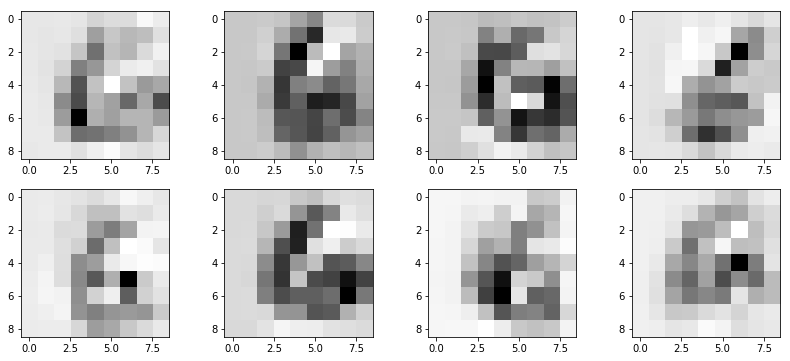

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(sample_qda(means, cov), cmap='Greys')